# 16 - TensorFlow - Keras: Clasificación de tendencias politicas en tweets (Perceptrón Multicapa)

* En este notebook vamos a clasificar una serie de tweets etiquetados por un partido político (psoe, pp, vox, podemos y ciudadanos) que corresponden a la tendencia politica de la cuenta que publicó ese tweet,


* El ejercicio que vamos a realizar a continuación es muy similar al realizado en el notebook *13_PoC_Tendencias_Politicas_Twitter_Generacion_Exportacion_Modelos.ipynb* y se pueden comparar los resultados que vamos a obtener con la Red Neuronal respecto a los obtenidos con los modelos generados por los algoritmos de clasificación vistos.


* Los pasos que vamos a dar son los siguientes:

    1. Cargar los datos
    2. Normalizar los tweets (igual que en el notebook *13_PoC_Tendencias_Politicas_Twitter_Generacion_Exportacion_Modelos.ipynb*)
    3. Particionado de datos (Train y Test)
    4. Bolsa de palabras y codificación del target
    5. Definición de la Red Neuronal
    6. Entrenamiento de la Red Neuronal
    7. Evaluación del modelo

<hr>


## Carga de Datos


* El fichero que contiene los tweets lo podemos leer como un '*csv*' con pandas pasandole como separador '***::::***'.


* Este fichero esta estructurado de la siguiente manera
    - **Cuenta**: Cuenta de twitter
    - **Partido**: Partido político al que pertenece (ciudadanos, podemos, pp, psoe)
    - **Timestamp**: Instante en el que se publicó el tweet
    - **Tweet**: Tweet.
    
    
* Leemos los datos y mostramos una muestra:

In [1]:
import pandas as pd

TWEETS_FILE = './data/tweets_politica.csv'
df = pd.read_csv(TWEETS_FILE, sep='::::', engine='python', error_bad_lines=False)

# Eliminamos los tweets que tengan algún valor a nulo
df = df.dropna()
print('Número de Tweets Cargados: {num}'.format(num=df.shape[0]))

# Imprimimos el número de tweets a procesar
print('Número de Tweets a procesar: {num}'.format(num=df.shape[0]))
df.sample(10)

Número de Tweets Cargados: 96017
Número de Tweets a procesar: 96017


,cuenta,partido,timestamp,tweet
58870,PODEMOS,podemos,1.583694e+09,"📣 Gritan: ""Sola, borracha, quiero llegar a cas..."
79882,PSOE,psoe,1.612542e+09,Debemos ser capaces de encontrar las reglas de...
32276,CristinaNarbona,psoe,1.573211e+09,Menos mal que algunos dicen cosas sensatas...C...
70529,ivanedlm,vox,1.609243e+09,"No hay error, hay maldad. Siguen el editorial ..."
43289,odonelorza2011,psoe,1.578773e+09,@UrizIglesias Ahora se trata de otro tipo de t...
7157,Igarrigavaz,vox,1.560355e+09,Hemos venido para cambiar las maneras de la p...
65613,vox_es,vox,1.585228e+09,⭕ Nuestro diputado y médico @jlsteeg al minist...
90239,ionebelarra,podemos,1.616243e+09,@monrosi Allí donde vayas ganan un magnífico p...
9089,odonelorza2011,psoe,1.562010e+09,@lolamontavez @yolanda262 @sinisterravente @cl...
55246,sanchezcastejon,psoe,1.582646e+09,Para responder a las necesidades de Cataluña y...


* Filtramos los tweets por fecha. Nos quedamos con los tweets a partir de una fecha dada.

In [2]:
import datetime
import time

# Filtramos los tweets a partir de una fecha
DATE = "01/01/2021"
timestamp = time.mktime(datetime.datetime.strptime(DATE, "%d/%m/%Y").timetuple())
df = df[df.timestamp >= timestamp]

# Mostramos un sample y el número de tweets a procesar
print('Número de Tweets a procesar: {num}'.format(num=df.shape[0]))
df.sample(10)

Número de Tweets a procesar: 23781


,cuenta,partido,timestamp,tweet
93518,DolorsMM,pp,1.617637e+09,Dice Marlaska que no tiene ninguna voluntad de...
86980,IreneMontero,podemos,1.615067e+09,Enhorabuena a @LozanoMabel por el premio a mej...
73522,eledhmel,vox,1.610277e+09,@cayojuliolacer https://t.co/fvSioBxWHE
85517,vox_es,vox,1.614525e+09,"➡ @Macarena_Olona ""Nuestro sitio no es el coch..."
92533,MiguelUrban,podemos,1.617175e+09,🎥 'Un barrio por un parque' es una película do...
77829,Tonicanto1,ciudadanos,1.611432e+09,El Jemad se vacunó tras recibir una instrucció...
72916,populares,pp,1.610018e+09,👉 @pablocasado_: “Todos los demócratas debería...
89861,carrizosacarlos,ciudadanos,1.616096e+09,El Supremo confirma las multas de la JEC a Tor...
80186,ivanedlm,vox,1.612564e+09,@ignaciopasamar Gracias amigo
77920,JuanMarin_Cs,ciudadanos,1.611229e+09,En @AndaluciaJunta apostamos por la #mediación...


* Tweets publicados por partido político

In [3]:
df.groupby('partido')['tweet'].count().reset_index().sort_values(by='tweet', ascending=False)

,partido,tweet
4,vox,6875
0,ciudadanos,4848
1,podemos,4398
3,psoe,4020
2,pp,3640


* Nos quedamos solo con el nombre del partido y el tweet

In [4]:
tweets = [tuple(x) for x in df[['tweet', 'partido']].values]
print('Número de Tweets Cargados: {num}'.format(num=len(tweets)))

Número de Tweets Cargados: 23781


<hr>


## Normalización

* Utilizamos ***spaCy*** para la tokenización y normalización.


* Tras realizar un análisis del contenido de los tweets pasamos a realizar las siguientes acciones para ***normalizar*** los tweets:
    1. Pasamos las frases a minúsculas.
    2. Sustituimos los puntos por espacios ya que hay muchas palabras unidas por un punto
    3. Quitamos la almuhadilla de los hashtags para considerarlos como palabras.
    4. Eliminamos los signos de puntuación.
    5. Eliminamos las palabras con menos de 3 caracteres.
    6. Eliminamos las Stop-Words.
    7. Eliminamos los enlaces(http) y las menciones (@)
    8. Pasamos la palabra a su lema


* Todos estos pasos los vamos a realizar en una misma función.


* ***NOTA***: Se pueden realizar más acciones de normalización que las realizadas, como tratamiento de emoticonos, tratamiento especial de referencia a cuentas, hashtags, etc. Al tratarse de un ejemplo didáctica se ha realizado una normalización '*sencilla*'.

In [5]:
import numpy as np
import spacy

from tqdm import tqdm

nlp = spacy.load('es_core_news_sm')

# Divido los datos en dos listas 
#     X: los tweets
#     y: target (polaridad)

X = [doc[0] for doc in tweets]
y = np.array([doc[1] for doc in tweets])

def normalize(sentenses):
    """normalizamos la lista de frases y devolvemos la misma lista de frases normalizada"""
    for index, sentense in enumerate(tqdm(sentenses)):
        # Tokenizamos el tweets realizando los puntos 1,2 y 3.
        sentense = nlp(sentense.lower().replace('.', ' ').replace('#', ' ').strip())
        # Puntos 4,5,6,7 y 8
        sentenses[index] = ([word.lemma_ for word in sentense if (not word.is_punct)
                             and (len(word.text) > 2) and (not word.is_stop)
                             and (not word.text.startswith('@'))
                             and (not word.text.startswith('http'))
                             and (not ':' in word.text)])
    return sentenses

# Normalizamos las frases
X_norm = normalize(X)

100%|██████████| 23781/23781 [03:25<00:00, 115.65it/s]


<hr>


## Particionado de Datos (Train y Test)

* Dado que las temáticas de los tweets varian en función del tiempo (tienen caracter temporal), vamos a particionar los datos temporalmente.


* Seleccionaremos como tweets de entrenamiento aquellos que se han escrito hasta una determinada fecha y como tweets de test los últimos tweets escritos.


* Seleccionaremos un 5% de tweets de test, siendo estos los últimos tweets registrados en el dataset (los tweets están escritos de manera cronológica).


* Por tanto nos vamos a quedar con:
    - 95% de datos de entrenamiento
    - 5% de datos de test

In [6]:
PCT_TEST = 0.05
n_tail = len(X_norm) - int(len(X_norm) * PCT_TEST)
print('Corte en el tweet número {} de los {} tweets del Dataset.'.format(n_tail, len(X_norm)))

X_train = X_norm[:n_tail]
y_train = y[:n_tail]
X_test = X_norm[n_tail:]
y_test = y[n_tail:]

print('Tweets de entrenamiento: {}'.format(len(X_train)))
print('Tweets de Test: {}'.format(len(X_test)))


Corte en el tweet número 22592 de los 23781 tweets del Dataset.
Tweets de entrenamiento: 22592
Tweets de Test: 1189


<hr>


# Bolsa de palabras y codificación del target


* Al igual que en el notebook *13_PoC_Tendencias_Politicas_Twitter_Generacion_Exportacion_Modelos.ipynb* vamos a trabajar con las 1500 palabras de mayor frecuencia del corpus.


* Realizaremos una codificación del nombre del partido político utilizando la clase "LabelEncoder()" de scikit.

In [7]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer


# Bolsa de Palabras
max_words = 1500
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_matrix = tokenizer.texts_to_matrix(X_train, mode='count')
X_matrix_test = tokenizer.texts_to_matrix(X_test, mode='count')

# Codificación del Target
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

<hr>


# Definición de la Red Neuronal



* Para clasificar los tweets en alguna de las 4 tendencias políticas definidas, vamos a crear una red con la siguiente arquitectura:
<span></span><br><br>
    - ***Capa 1***: Capa de entrada con 1000 Neuronas (una por palabra del corpus)
<span></span><br><br>
    - ***Capa 2***: 20 Neuronas con una función de activación 'relu'
<span></span><br><br>
    - ***Capa 3***: 10 Neuronas con una función de activación 'relu'
<span></span><br><br>
    - ***Capa 4***: Capa de salida con 5 neurona (una por tendencia política) y una función de activación 'softmax' para que nos "normalice la salida"
    
    
* Para las capas 2 y 3 vamos a poner un dropout del 20% para que nuestra red no se sobreajuste y generalize mejor


* Por último vamos a compilar la red:
<span></span><br><br>
    - ***Función de perdida: 'categorical_crossentropy'*** (Funciones de Perdida: https://keras.io/losses/)
<span></span><br><br>
    - ***Optimizador: 'adam'*** (Optimizadores: https://keras.io/optimizers/)
<span></span><br><br>
    - Metricas: en cada epoch pediremos que nos muestre el accuracy.

In [8]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import metrics

np.random.seed(9)
model = Sequential()
model.add(Dense(20, activation='relu', input_dim=max_words))
model.add(Dropout(0.2))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


* Una vez creada la red mostramos su arquitectura:
    - 1000 Neuronas de entrada
    - Capa 2: 20 Neuronas
    - Conexiones "capa de entrada -> Capa 2" = (1000*20) + 20 = 20020 Conexiones
    - Capa 3: 10 Neuronas
    - Conexiones "Capa 2 -> Capa 3" = (20*10) + 10 = 210 Conexiones
    - Capa de salida: 4 Neuronas
    - Conexiones "Capa 3 -> Capa de salida" = (10*5) + 5 = 55 Conexiones

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                30020     
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 55        
Total params: 30,285
Trainable params: 30,285
Non-trainable params: 0
_________________________________________________________________


<hr>


# Entrenamiento de la Red Neuronal


* Como lo que estamos haciendo es un ejemplo didáctico vamos a poner los siguientes valores:
<span></span><br><br>
    - *batch_size = 32* : Cada 32 tweets se calculan los nuevos pesos de la red
<span></span><br><br>
    - *epochs = 100*
<span></span><br><br>
    - *validation_split = 0.1* 


In [10]:

history = model.fit(X_matrix, y_train, batch_size=32, epochs=100, verbose=2, validation_split=0.1)


Epoch 1/100
636/636 - 1s - loss: 1.3605 - accuracy: 0.4452 - val_loss: 1.1202 - val_accuracy: 0.5929
Epoch 2/100
636/636 - 0s - loss: 1.0645 - accuracy: 0.5968 - val_loss: 1.0251 - val_accuracy: 0.6035
Epoch 3/100
636/636 - 1s - loss: 0.9588 - accuracy: 0.6477 - val_loss: 0.9998 - val_accuracy: 0.6128
Epoch 4/100
636/636 - 1s - loss: 0.8953 - accuracy: 0.6689 - val_loss: 0.9932 - val_accuracy: 0.6133
Epoch 5/100
636/636 - 1s - loss: 0.8468 - accuracy: 0.6879 - val_loss: 1.0023 - val_accuracy: 0.6106
Epoch 6/100
636/636 - 1s - loss: 0.8155 - accuracy: 0.7003 - val_loss: 1.0281 - val_accuracy: 0.6080
Epoch 7/100
636/636 - 1s - loss: 0.7831 - accuracy: 0.7140 - val_loss: 1.0318 - val_accuracy: 0.6044
Epoch 8/100
636/636 - 0s - loss: 0.7608 - accuracy: 0.7250 - val_loss: 1.0573 - val_accuracy: 0.6004
Epoch 9/100
636/636 - 0s - loss: 0.7382 - accuracy: 0.7306 - val_loss: 1.0690 - val_accuracy: 0.6058
Epoch 10/100
636/636 - 1s - loss: 0.7145 - accuracy: 0.7393 - val_loss: 1.0849 - val_accura

Epoch 82/100
636/636 - 0s - loss: 0.4031 - accuracy: 0.8541 - val_loss: 2.7871 - val_accuracy: 0.5708
Epoch 83/100
636/636 - 0s - loss: 0.4012 - accuracy: 0.8520 - val_loss: 2.8606 - val_accuracy: 0.5765
Epoch 84/100
636/636 - 0s - loss: 0.4063 - accuracy: 0.8492 - val_loss: 2.7988 - val_accuracy: 0.5712
Epoch 85/100
636/636 - 1s - loss: 0.3932 - accuracy: 0.8531 - val_loss: 2.8490 - val_accuracy: 0.5677
Epoch 86/100
636/636 - 0s - loss: 0.4025 - accuracy: 0.8541 - val_loss: 2.8739 - val_accuracy: 0.5708
Epoch 87/100
636/636 - 0s - loss: 0.3988 - accuracy: 0.8536 - val_loss: 2.8907 - val_accuracy: 0.5721
Epoch 88/100
636/636 - 0s - loss: 0.3952 - accuracy: 0.8528 - val_loss: 2.8885 - val_accuracy: 0.5659
Epoch 89/100
636/636 - 0s - loss: 0.4044 - accuracy: 0.8502 - val_loss: 2.9020 - val_accuracy: 0.5650
Epoch 90/100
636/636 - 0s - loss: 0.3954 - accuracy: 0.8519 - val_loss: 2.9716 - val_accuracy: 0.5735
Epoch 91/100
636/636 - 0s - loss: 0.3984 - accuracy: 0.8568 - val_loss: 2.9753 - v

* Pintamos como evoluciona la función de perdida y el Accuracy por epoch tanto en entrenamiento como en test.

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

# Pintamos las métricas por epoch
def plot_metric(history, name, remove_first=0):
    metric_train = np.array(history.history[name])[remove_first:]
    metric_test = np.array(history.history['val_{}'.format(name)])[remove_first:]
    acum_avg_metric_train = (np.cumsum(metric_train) / (np.arange(metric_train.shape[-1]) + 1))[remove_first:]
    acum_avg_metric_test = (np.cumsum(metric_test) / (np.arange(metric_test.shape[-1]) + 1))[remove_first:]
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.title('{} - Epochs'.format(name))
    plt.plot(metric_train, label='{} Train'.format(name))
    plt.plot(metric_test, label='{} Test'.format(name))
    plt.grid()
    plt.legend(loc='upper center')
    plt.subplot(1, 2, 2)
    plt.title('AVG ACCUMULATIVE {} - Epochs'.format(name))
    plt.plot(acum_avg_metric_train, label='{} Train'.format(name))
    plt.plot(acum_avg_metric_test, label='{} Test'.format(name))
    plt.grid()
    plt.legend(loc='upper center')
    plt.show()

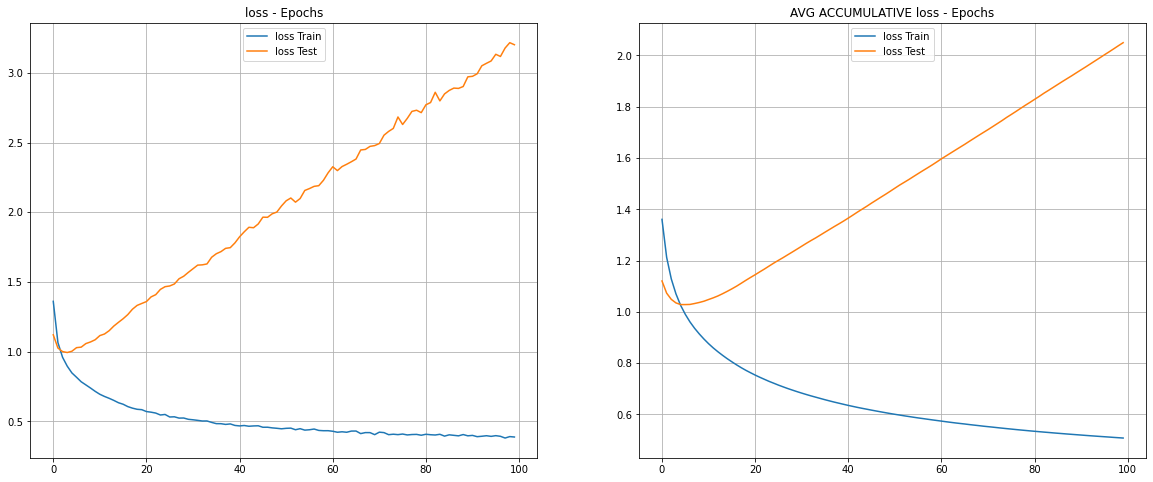

In [12]:
# Función de perdida
plot_metric(history=history, name='loss')

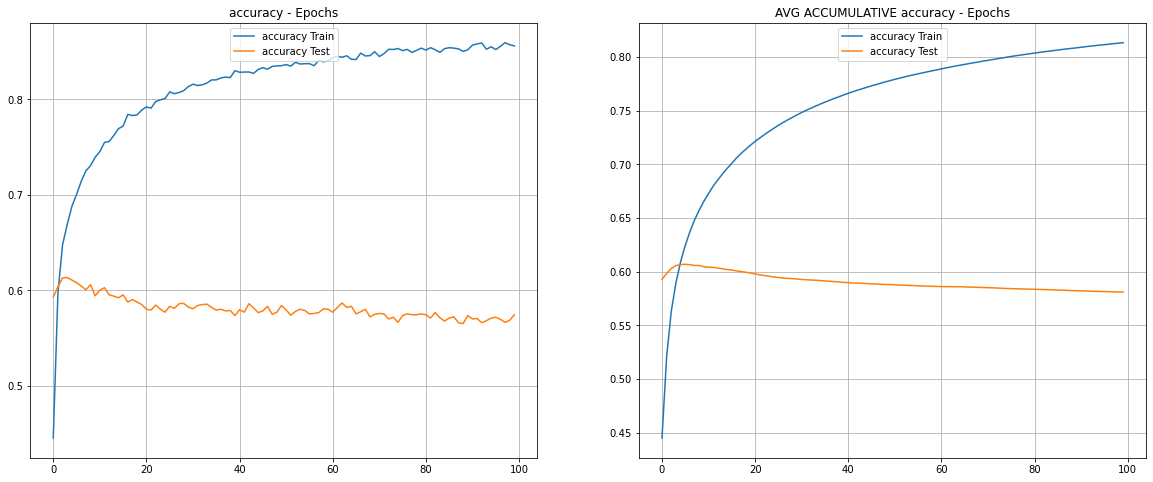

In [13]:
# Accuracy
plot_metric(history=history, name='accuracy')

<hr>


# Evaluamos el modelo

* Pasamos a evaluar el modelo, calculando las siguientes métricas de evaluación:

    1. **Accuracy**
    2. **Precision**
    3. **Recall**
    4. **F1**

In [14]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

y_true = encoder.inverse_transform(y_test.reshape(-1))
y_pred = model.predict_classes(X_matrix_test)
y_pred = encoder.inverse_transform(y_pred.reshape(-1))

print('Accuracy: {acc:0.4f}'.format(acc=accuracy_score(y_true=y_true, y_pred=y_pred)))
print('F1: {f1:0.4f}'.format(f1=f1_score(y_true=y_true, y_pred=y_pred, average='weighted')))
print('Precision: {pre:0.4f}'.format(pre=precision_score(y_true=y_true, y_pred=y_pred, average='weighted')))
print('Recall: {rec:0.4f}'.format(rec=recall_score(y_true=y_true, y_pred=y_pred, average='weighted')))
print(classification_report(y_true=y_true, y_pred=y_pred))
labels = ['psoe', 'pp', 'vox', 'podemos', 'ciudadanos']
confusion_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=labels)


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Accuracy: 0.5509
F1: 0.5426
Precision: 0.5473
Recall: 0.5509
              precision    recall  f1-score   support

  ciudadanos       0.57      0.48      0.52       242
     podemos       0.55      0.50      0.52       252
          pp       0.47      0.47      0.47       196
        psoe       0.52      0.38      0.44       176
         vox       0.59      0.78      0.67       323

    accuracy                           0.55      1189
   macro avg       0.54      0.52      0.53      1189
weighted avg       0.55      0.55      0.54      1189



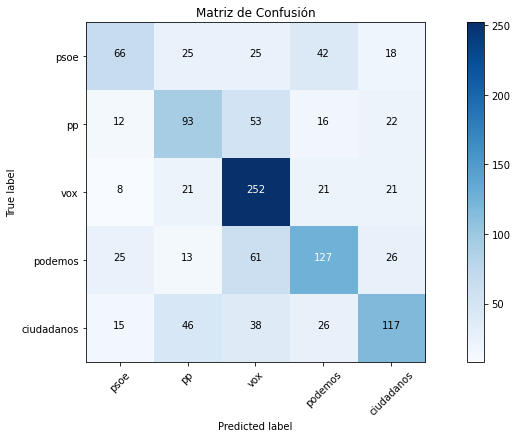

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

def plot_confusion_matrix(cm, classes, title, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Pintamos la matriz de confusión
plt.figure(figsize=(12, 6))
plot_confusion_matrix(confusion_matrix, classes=labels, title='Matriz de Confusión')
plt.show()